In [105]:
%matplotlib inline
import matplotlib.pyplot as plt
import simtk.openmm as mm
from torsionfit import TorsionScanSet as ScanSet
import torsionfit.TorsionFitModel as Model
from torsionfit import sqlite_plus
from pymc import MCMC
from parmed.charmm import CharmmParameterSet
from torsionfit import plots
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
from scipy import optimize

In [2]:
param_to_opt=[('CG331', 'CG321', 'CG321', 'CG331')]
param = CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
structure = 'structure/butane.psf'
scan = 'MP2_torsion_scan/'
# Print initial guess
print param.dihedral_types[param_to_opt[0]]

# Create a butane scan with torsions on (to compare for difference potential)
butane_scan = ScanSet.parse_psi4_out(scan, structure)
butane_scan.compute_energy(param)
optimized = butane_scan.remove_nonoptimized()
optimized.compute_energy(param)

# Turn off torsion
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
param.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0

# Create butane scan with torsions off
optimized_0 = butane_scan.remove_nonoptimized()
optimized_0.compute_energy(param)

<DihedralTypes [<DihedralType; phi_k=0.038, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.032, per=6, phase=180.000,  scee=1.000, scnb=1.000>]>
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/0/butane_0.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/10/butane_10.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions/examples/butane/MP2_torsion_scan/20/butane_20.out2 WARNING] In logfileparser.py, line 467, line not all dashes as expected: --------------------------------------------------------------------------------------------- ~
[Psi /Users/chayastern/src/ChayaSt/Torsions

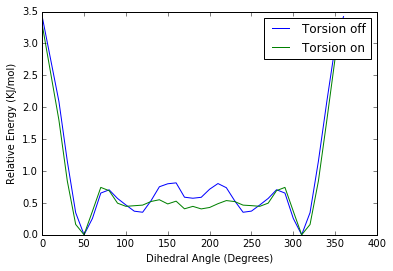

In [3]:
plt.plot(optimized_0.steps, optimized_0.delta_energy-min(optimized_0.delta_energy), label='Torsion off')
plt.plot(optimized.steps, optimized.delta_energy-min(optimized.delta_energy), label='Torsion on')
plt.legend()
plt.xlabel('Dihedral Angle (Degrees)')
plt.ylabel('Relative Energy (KJ/mol)')

In [156]:
param0=CharmmParameterSet('../data/charmm_ff/top_all36_cgenff.rtf', '../data/charmm_ff/par_all36_cgenff.prm')
# add missing parameters
from parmed.topologyobjects import DihedralType

for i in [1, 3, 4, 5]:
    param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')].append(DihedralType(0, i, 0))
# Set all parameters to 0
#param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][1].phi_k=0
#param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][0].phi_k=0
param0.dihedral_types[('HGA3', 'CG331', 'CG321', 'HGA2')][0].phi_k=0
param0.dihedral_types[('HGA2', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param0.dihedral_types[('HGA3', 'CG331', 'CG321', 'CG321')][0].phi_k=0
param0.dihedral_types[('CG321', 'CG321', 'CG331', 'HGA3')][0].phi_k=0
param0.dihedral_types[('HGA2', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param0.dihedral_types[('CG331', 'CG321', 'CG321', 'HGA2')][0].phi_k=0
param0.bond_types[('CG331', 'CG321')].k=0
param0.bond_types[('CG321', 'CG321')].k=0
param0.bond_types[('CG331', 'HGA3')].k=0
param0.bond_types[('CG321', 'HGA2')].k=0
param0.urey_bradley_types[('CG331', 'CG321', 'CG321')].k  = 0
param0.urey_bradley_types[('CG331', 'CG321', 'HGA2')].k = 0
param0.urey_bradley_types[('CG321', 'CG321', 'HGA2')].k = 0
param0.urey_bradley_types[('HGA3', 'CG331', 'CG321')].k = 0
param0.urey_bradley_types[('HGA3', 'CG331', 'HGA3')].k = 0
param0.urey_bradley_types[('HGA2', 'CG321', 'HGA2')].k = 0

param0.angle_types[('CG331', 'CG321', 'CG321')].k  = 0
param0.angle_types[('CG331', 'CG321', 'HGA2')].k = 0
param0.angle_types[('CG321', 'CG321', 'HGA2')].k = 0
param0.angle_types[('HGA3', 'CG331', 'CG321')].k = 0
param0.angle_types[('HGA3', 'CG331', 'HGA3')].k = 0
param0.angle_types[('HGA2', 'CG321', 'HGA2')].k = 0

# Turn off LJ
param0.atom_types['CG331'].sigma_14 = 1.0
param0.atom_types['CG331'].rmin = 1.0
param0.atom_types['CG331'].rmin_14 = 1.0
param0.atom_types['CG331'].epsilon_14 = 0
param0.atom_types['CG331'].sigma=1.0
param0.atom_types['CG331'].epsilon = 0.0
param0.atom_types['CG321'].epsilon_14 = 0.0
param0.atom_types['CG321'].rmin_14 = 1.0
param0.atom_types['CG321'].sigma_14 = 1.0
param0.atom_types['CG321'].sigma=1.0
param0.atom_types['CG321'].epsilon = 0.0
param0.atom_types['HGA3'].epsilon_14 = 0.0
param0.atom_types['HGA3'].sigma = 1.0
param0.atom_types['HGA3'].epsilon = 0.0
param0.atom_types['HGA2'].epsilon_14 = 0.0
param0.atom_types['HGA2'].sigma = 1.0
param0.atom_types['HGA2'].epsilon = 0.0

In [157]:
only_torsion_2 = butane_scan.remove_nonoptimized()
only_torsion_2.compute_energy(param0)

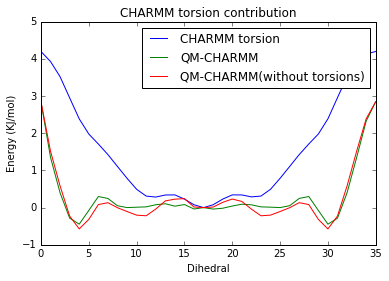

In [158]:
plt.plot(only_torsion_2.mm_energy, label='CHARMM torsion')
plt.plot(optimized.delta_energy, label='QM-CHARMM')
plt.plot(optimized_0.delta_energy, label='QM-CHARMM(without torsions)')
plt.legend()
plt.title('CHARMM torsion contribution')
plt.xlabel('Dihedral')
plt.ylabel('Energy (KJ/mol)')
plt.savefig('CHARMM_torsion.png')


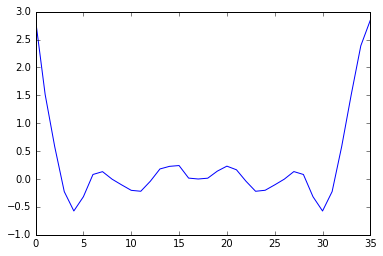

In [151]:
#plt.plot(only_torsion.mm_energy)
target = optimized_0.delta_energy
plt.plot(target)

In [121]:
import simtk.unit as u
def energy(param):
    for i in range(6):
        param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][i].phi_k = param[i]
        #param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')][i].phase = param[i+1]
    # reparameterize butane
    only_torsion.integrator = mm.VerletIntegrator(0.004*u.picoseconds)
    only_torsion.create_context(param0)
    only_torsion.compute_energy(param0)
    return only_torsion.mm_energy._value

def residuals(param):
    mm_energy = energy(param)
    return np.sum((mm_energy-target._value)**2)
        

In [139]:
param0.dihedral_types[('CG331', 'CG321', 'CG321', 'CG331')]


<DihedralTypes [<DihedralType; phi_k=0.119, per=2, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=-0.002, per=6, phase=180.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=-0.323, per=1, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.038, per=3, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.079, per=4, phase=0.000,  scee=1.000, scnb=1.000>, <DihedralType; phi_k=0.002, per=5, phase=0.000,  scee=1.000, scnb=1.000>]>

In [123]:
initial_guess = [0, 0, 0, 0, 0, 0]
energy(initial_guess)
fit = optimize.minimize(residuals,initial_guess,method='Nelder-Mead')

In [124]:
fit.x

array([ 0.11920624, -0.00171476, -0.32283999,  0.03805658,  0.07938943,
        0.00237631])

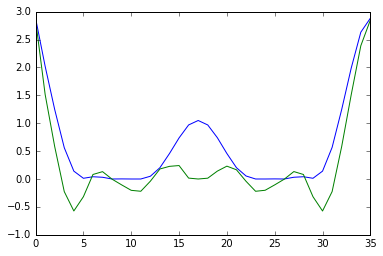

In [150]:
#plt.plot(only_torsion.delta_energy)
plt.plot(only_torsion.mm_energy)
plt.plot(optimized_0.delta_energy)
#plt.plot(optimized.qm_energy, '.')

In [140]:
fit.x

array([ 0.11920624, -0.00171476, -0.32283999,  0.03805658,  0.07938943,
        0.00237631])

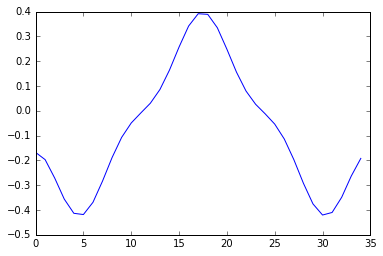

In [146]:
plt.plot(fit.x[0]*(1+np.cos(2*x)) + fit.x[1]*(1+np.cos(6*x-np.pi)) + fit.x[2]*(1+np.cos(x)) 
         + fit.x[3]*(1+np.cos(3*x)) + fit.x[4]*(1+np.cos(4*x)) + fit.x[5]*(1+np.cos(5*x)))

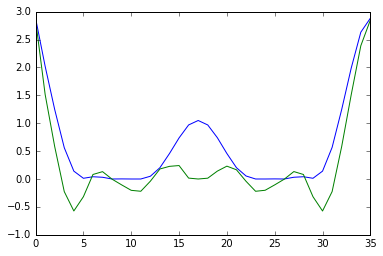

In [152]:
plt.plot(only_torsion.mm_energy)
plt.plot(target)